# Optimising GNNs on QM9 using Ax-Bayesian Optimisation

In [1]:
!pip install torch --quiet
!pip install torch_geometric --quiet
!pip install ax_platform --quiet
!pip install botorch --quiet

In [ ]:
## Imports
import copy
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import GRU, Linear, ReLU, Sequential

import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set
from torch_geometric.utils import remove_self_loops
import plotly.graph_objects as go
import gc
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from pathlib import Path


from ax.storage.json_store.save import save_experiment
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.service.ax_client import AxClient, ObjectiveProperties
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import Draw  # To draw the molecules

In [ ]:
# Seed everything

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

In [2]:
# Set the path for QM9

qm9_dir = "qm9_data"
Path(qm9_dir).mkdir(parents=True, exist_ok=True)


target = 7 # Internal energy
dim = 64

In [3]:
class MyTransform:
    """"Selects the target variable"""
    def __call__(self, data):
        data = copy.copy(data)
        data.y = data.y[:, target]  # Specify target.
        return data


class Complete:
    """Makes a fully connected graph"""
    def __call__(self, data):
        data = copy.copy(data)
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data



transform = T.Compose([MyTransform(), Complete(), T.Distance(norm=False)])
# Originalmente: Carga y preparación del dataset
dataset = QM9(qm9_dir, transform=transform).shuffle()

# Modificación para usar un subconjunto más pequeño
# Por ejemplo, usar solo los primeros 10,000 datos del dataset
subset_size = 1000  # Define el tamaño del subconjunto
subset_indices = torch.randperm(len(dataset))[:subset_size]  # Selecciona índices al azar
dataset = dataset[subset_indices]

# Procede como antes
mean = dataset.data.y.mean(dim=0, keepdim=True)
std = dataset.data.y.std(dim=0, keepdim=True)
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean[:, target].item(), std[:, target].item()

# Split datasets teniendo en cuenta el nuevo tamaño
test_dataset = dataset[:int(subset_size*0.2)]
val_dataset = dataset[int(subset_size*0.2):int(subset_size*0.4)]
train_dataset = dataset[int(subset_size*0.4):]

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

#________________________________________________________________________________________________
#RED NEURONAL ARQUITECTURA

class Net(torch.nn.Module):
    def __init__(self,dim=64, num_neurons=128):
        super().__init__()
        self.lin0 = torch.nn.Linear(dataset.num_features, dim)

        nn = Sequential(Linear(5, num_neurons), ReLU(), Linear(num_neurons, dim * dim))
        self.conv = NNConv(dim, dim, nn, aggr='mean')
        self.gru = GRU(dim, dim)

        self.set2set = Set2Set(dim, processing_steps=3)
        self.lin1 = torch.nn.Linear(2 * dim, dim)
        self.lin2 = torch.nn.Linear(dim, 1)
#________________________________________________________________________________________________
#PROPAGACIÓN DE INFORMACIÓN
    def forward(self, data):
        out = F.relu(self.lin0(data.x))
        h = out.unsqueeze(0)

        for i in range(3):
            m = F.relu(self.conv(out, data.edge_index, data.edge_attr))
            out, h = self.gru(m.unsqueeze(0), h)
            out = out.squeeze(0)

        out = self.set2set(out, data.batch)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out.view(-1)
#________________________________________________________________________________________________

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


c:\Users\AntObi\anaconda3\envs\BO_chem\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [4]:
# Helper functions for training
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train(model, train_loader, optimizer, device):
    """Train a model
    
    Args:
        model (torch.nn.Module): Model to train
        train_loader (DataLoader): Training data loader
        optimizer (torch.optim.Optimizer): Optimizer to use
        device (torch.device): Device to use

    Returns:
        float: Average training loss
    """
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)

def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):
    
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)
    
    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)
        
        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)
        
        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')
        
        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))
    
    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")
    
    return best_val_error, test_error, train_time, perf_per_epoch


In [5]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

Below we will train the baseline model

In [6]:
# Train the model

num_epochs = 20
model = Net(dim=dim, num_neurons=128)
model_name=type(model).__name__

best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=num_epochs
)
RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = pd.concat([DF_RESULTS,df_temp], ignore_index=True)

Running experiment for Net, training on 600 samples for 20 epochs.

Model architecture:
Net(
  (lin0): Linear(in_features=11, out_features=64, bias=True)
  (conv): NNConv(64, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4096, bias=True)
  ))
  (gru): GRU(64, 64)
  (set2set): Set2Set(64, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 617025

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.7244506, Val MAE: 655.1737109, Test MAE: 711.4793359
Epoch: 020, LR: 0.001000, Loss: 0.3978573, Val MAE: 504.9608594, Test MAE: 458.0982813

Done! Training took 2.00 mins. Best validation MAE: 452.4456836, corresponding test MAE: 458.0982813.


C:\Users\AntObi\AppData\Local\Temp\ipykernel_44644\603147491.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  DF_RESULTS = pd.concat([DF_RESULTS,df_temp], ignore_index=True)


In [7]:
DF_RESULTS

,Test MAE,Val MAE,Epoch,Model
0,859.589316,807.810273,1,Net
1,860.035625,800.001582,2,Net
2,831.038281,794.388418,3,Net
3,763.292070,726.041836,4,Net
4,763.292070,767.920059,5,Net
5,691.422598,691.698008,6,Net
6,691.422598,758.756836,7,Net
7,691.422598,749.105234,8,Net
8,699.813398,688.416094,9,Net
9,711.479336,655.173711,10,Net


<Axes: xlabel='Epoch', ylabel='Val MAE'>

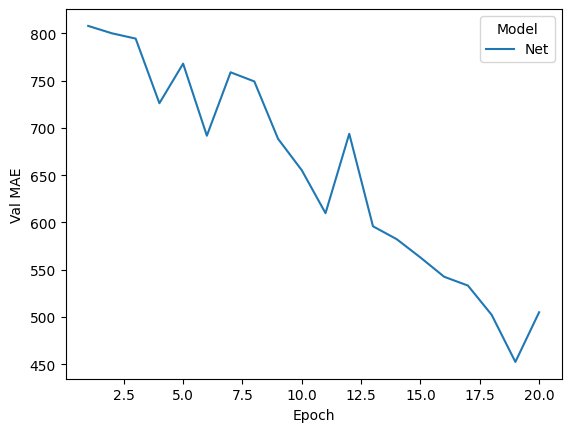

In [8]:
sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)

## Ax Hyperparameter BO

The example below focuses on trying to optimise the number of neurons in the network.

In [9]:
parameters = [
    #{"name":"dim", "type":"range", "bounds":[32, 256], "value_type":"int", "log_scale":False},
    {"name":"num_neurons", "type":"range", "bounds":[32, 256], "value_type":"int", "log_scale":False},
]

def train_evaluate(parameterization):
    #dim = parameterization.get("dim")
    num_neurons = parameterization.get("num_neurons")
    model = Net(
        dim=dim,
        num_neurons=num_neurons
        )
    model_name=type(model).__name__
    
    best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
        model, 
        model_name, 
        train_loader,
        val_loader, 
        test_loader,
        n_epochs=num_epochs
    )
    del model
    gc.collect()
    torch.cuda.empty_cache()
    return {"val_error": (best_val_error, 0.0)}

# define the objective with the name "mae" (mean absolute error) and minimize=True
#objectives = {"val_error": ObjectiveProperties(minimize=True)}  # IMPLEMENT

# Instantiate the AxClient class with `random_seed=42` for reproducibility
#ax_client = AxClient(random_seed=42)
#ax_client.create_experiment(parameters=parameters, objectives=objectives)


best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=train_evaluate,
    objective_name='val_error',
    total_trials=3,
    minimize=True
)

print(best_parameters)
print(values)

[INFO 03-28 15:18:13] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='num_neurons', parameter_type=INT, range=[32, 256])], parameter_constraints=[]).
[INFO 03-28 15:18:13] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 03-28 15:18:13] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=1 num_trials=None use_batch_trials=False
[INFO 03-28 15:18:13] ax.modelbridge.dispatch_utils: calculated num_initialization_trials=5
[INFO 03-28 15:18:13] ax.modelbridge.dispatch_utils: num_completed_initialization_trials=0 num_remaining_initialization_trials=5
[INFO 03-28 15:18:13] ax.modelbridge.dispatch_utils: `verbose`, `disable_progbar`, and `jit_compile` are not yet supported when using `choose_generation_

Running experiment for Net, training on 600 samples for 20 epochs.

Model architecture:
Net(
  (lin0): Linear(in_features=11, out_features=64, bias=True)
  (conv): NNConv(64, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=5, out_features=164, bias=True)
    (1): ReLU()
    (2): Linear(in_features=164, out_features=4096, bias=True)
  ))
  (gru): GRU(64, 64)
  (set2set): Set2Set(64, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 764697

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.4689528, Val MAE: 599.4375977, Test MAE: 547.7867969
Epoch: 020, LR: 0.001000, Loss: 0.2972341, Val MAE: 406.1959961, Test MAE: 396.4939355

Done! Training took 2.08 mins. Best validation MAE: 406.1959961, corresponding test MAE: 396.4939355.


[INFO 03-28 15:20:18] ax.service.managed_loop: Running optimization trial 2...


Running experiment for Net, training on 600 samples for 20 epochs.

Model architecture:
Net(
  (lin0): Linear(in_features=11, out_features=64, bias=True)
  (conv): NNConv(64, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=5, out_features=78, bias=True)
    (1): ReLU()
    (2): Linear(in_features=78, out_features=4096, bias=True)
  ))
  (gru): GRU(64, 64)
  (set2set): Set2Set(64, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 411925

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.4412438, Val MAE: 495.5994727, Test MAE: 519.9556055
Epoch: 020, LR: 0.001000, Loss: 0.2666579, Val MAE: 383.2060742, Test MAE: 377.0720605

Done! Training took 1.69 mins. Best validation MAE: 378.5245508, corresponding test MAE: 377.0720605.


[INFO 03-28 15:22:00] ax.service.managed_loop: Running optimization trial 3...


Running experiment for Net, training on 600 samples for 20 epochs.

Model architecture:
Net(
  (lin0): Linear(in_features=11, out_features=64, bias=True)
  (conv): NNConv(64, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=5, out_features=181, bias=True)
    (1): ReLU()
    (2): Linear(in_features=181, out_features=4096, bias=True)
  ))
  (gru): GRU(64, 64)
  (set2set): Set2Set(64, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 834431

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.5549095, Val MAE: 709.5707031, Test MAE: 648.9721289
Epoch: 020, LR: 0.001000, Loss: 0.3398796, Val MAE: 426.9989160, Test MAE: 428.0541016

Done! Training took 2.23 mins. Best validation MAE: 426.9989160, corresponding test MAE: 428.0541016.
{'num_neurons': 78}
({'val_error': 378.52455078125}, {'val_error': {'val_error': 0.0}})


In [12]:
trials = experiment.trials.values()

best_objectives = np.array([[trial.objective_mean for trial in trials]])
best_objective_plot = optimization_trace_single_method(
    y=best_objectives,
    optimization_direction="minimize",
    ylabel="MAE",
    #hover_labels=parameter_strs,
    plot_trial_points=True,
)
data = best_objective_plot[0]["data"]
layout = best_objective_plot[0]["layout"]


In [15]:
# Plot the figure
fig = go.Figure(data=data, layout=layout)
fig.show()

### Dataset Size

The example below observes the effect of dataset size

We will try to explore the optimal dataset size using bayesian optimisation

In [25]:
# Dataset size is the parameter to be optimised

# Define the parameters

parameters = [
    {"name": "train_size", "type": "range", "bounds": [0.2, 1.0], "log_scale": False},
]

# Define the evaluation function

def train_evaluate(parameterization):
    # Use the pre-defined train_dataset
    train_size = parameterization.get("train_size")
    train_dataset = dataset[int(subset_size*0.4):] 
    # Use a fraction of the dataset
    train_dataset= train_dataset[:int(train_size*len(train_dataset))]
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
   

    model = Net(dim=dim, num_neurons=128)
    model_name=type(model).__name__

    best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
        model, 
        model_name, 
        train_loader,
        val_loader, 
        test_loader,
        n_epochs=num_epochs
    )
    del model
    gc.collect()
    torch.cuda.empty_cache()

    # Add a penalty term for the training time and dataset size
    results = {"val_error": (best_val_error, 0.0),"train_time":(train_time, 0.0),"train_size":(train_size, 0.0)}
    results["val_error_penalty"] = results["val_error"][0] + train_time/1000 + train_size/1000 # Need to determine an appropriate penalty term
    return results

    
best_parameters, values, experiment, model = optimize(
parameters=parameters,
evaluation_function=train_evaluate,
objective_name='val_error_penalty',
total_trials=3,
minimize=True
)

print(best_parameters)
print(values)


[INFO 03-28 15:54:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter train_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-28 15:54:43] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='train_size', parameter_type=FLOAT, range=[0.2, 1.0])], parameter_constraints=[]).
[INFO 03-28 15:54:43] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 03-28 15:54:43] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=1 num_trials=None use_batch_trials=False
[INFO 03-28 15:54:43] ax.modelbridge.dispatch_utils: calculated num_initialization_trials=5
[INFO 03-28 15:54:43] ax

338
Running experiment for Net, training on 338 samples for 20 epochs.

Model architecture:
Net(
  (lin0): Linear(in_features=11, out_features=64, bias=True)
  (conv): NNConv(64, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4096, bias=True)
  ))
  (gru): GRU(64, 64)
  (set2set): Set2Set(64, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 617025

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.7405255, Val MAE: 0.6514916, Test MAE: 0.5344418
Epoch: 020, LR: 0.001000, Loss: 0.4933398, Val MAE: 0.6090705, Test MAE: 0.4271696

Done! Training took 1.08 mins. Best validation MAE: 0.4313646, corresponding test MAE: 0.4271696.


[INFO 03-28 15:55:50] ax.core.experiment: Attached data has some metrics ({'train_time', 'train_size'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experiment. For these metrics to be automatically fetched by `experiment.fetch_data`, add them via `experiment.add_tracking_metric` or update the experiment's optimization config.
[INFO 03-28 15:55:50] ax.service.managed_loop: Running optimization trial 2...


490
Running experiment for Net, training on 490 samples for 20 epochs.

Model architecture:
Net(
  (lin0): Linear(in_features=11, out_features=64, bias=True)
  (conv): NNConv(64, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4096, bias=True)
  ))
  (gru): GRU(64, 64)
  (set2set): Set2Set(64, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 617025

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.6136140, Val MAE: 0.4991317, Test MAE: 0.4828117
Epoch: 020, LR: 0.001000, Loss: 0.3375688, Val MAE: 0.4422661, Test MAE: 0.4060277

Done! Training took 1.38 mins. Best validation MAE: 0.4058731, corresponding test MAE: 0.4060277.


[INFO 03-28 15:57:13] ax.core.experiment: Attached data has some metrics ({'train_time', 'train_size'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experiment. For these metrics to be automatically fetched by `experiment.fetch_data`, add them via `experiment.add_tracking_metric` or update the experiment's optimization config.
[INFO 03-28 15:57:13] ax.service.managed_loop: Running optimization trial 3...


292
Running experiment for Net, training on 292 samples for 20 epochs.

Model architecture:
Net(
  (lin0): Linear(in_features=11, out_features=64, bias=True)
  (conv): NNConv(64, 64, aggr=mean, nn=Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4096, bias=True)
  ))
  (gru): GRU(64, 64)
  (set2set): Set2Set(64, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 617025

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.6976087, Val MAE: 0.5872365, Test MAE: 0.5398155
Epoch: 020, LR: 0.001000, Loss: 0.5860211, Val MAE: 0.4674075, Test MAE: 0.4635357

Done! Training took 1.02 mins. Best validation MAE: 0.4647324, corresponding test MAE: 0.4635357.


[INFO 03-28 15:58:14] ax.core.experiment: Attached data has some metrics ({'train_time', 'train_size'}) that are not among the metrics on this experiment. Note that attaching data will not automatically add those metrics to the experiment. For these metrics to be automatically fetched by `experiment.fetch_data`, add them via `experiment.add_tracking_metric` or update the experiment's optimization config.


{'train_size': 0.81675476282835}
({'val_error': 0.4058730697631836, 'train_time': 1.3800097068150838, 'train_size': 0.81675476282835}, {'val_error': {'val_error': 0.0}, 'train_time': {'train_time': 0.0}, 'train_size': {'train_size': 0.0}})


In [26]:
# Plot the results
trials = experiment.trials.values()

best_objectives = np.array([[trial.objective_mean for trial in trials]])
best_objective_plot = optimization_trace_single_method(
    y=best_objectives,
    optimization_direction="minimize",
    ylabel="MAE",
    #hover_labels=parameter_strs,
    plot_trial_points=True,
)
data = best_objective_plot[0]["data"]
layout = best_objective_plot[0]["layout"]


# Plot the figure
fig = go.Figure(data=data, layout=layout)
fig.show()

## Future plans
Implementing a method which the dataset size as an extra degree of freedom during a hyperparameter search would be the next steps to truly understand dataset efficiency (https://ml.informatik.uni-freiburg.de/wp-content/uploads/papers/15-BayesOpt-EnvES.pdf)
